# MetaPro-IQ

In [1]:
import skbio
import pandas as pd
import numpy as np
import os 
import shutil
import scipy.stats
import scikit_posthocs as ph
import numpy as np
#import Bio
import scipy.stats
#import scikit_posthocs as ph
import numpy as np
import matplotlib_venn
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.pyplot as plt
from pylab import *
from IPython.display import Image

In [2]:
%load_ext autoreload
%autoreload 1
%aimport metanovo_functions

### 1.1 Preprocessing

In [107]:
metanovo_uniprot    = 'data/mli/metanovo/txt' # path to the MetaNovo txt file, obtainable from PRIDE
txt_workflow = 'data/mli/txt_workflow'
txt_matched_metagenome ='data/mli/txt_matched_metagenome'
outfolder = 'analysis/mli/'

In [108]:
paths = ['analysis/figures', 'analysis/supplementary' ] 
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

In [109]:
# MetaNovo Parameters
summary = pd.read_csv(metanovo_uniprot + '/summary.txt',sep='\t')
summary[16:].stack()
parameters = pd.read_csv(metanovo_uniprot + '/parameters.txt',sep='\t')

In [110]:
# MetaNovo Summary
summary = pd.read_csv(metanovo_uniprot + '/summary.txt',sep='\t')
summary[16:].stack()

16  Raw file                                          Total
    MS                                             198071.0
    MS/MS                                          483091.0
    MS/MS Submitted                                523865.0
    MS/MS Submitted (SIL)                          442317.0
    MS/MS Submitted (ISO)                               0.0
    MS/MS Submitted (PEAK)                          81548.0
    MS/MS Identified                               190538.0
    MS/MS Identified (SIL)                         185701.0
    MS/MS Identified (ISO)                              0.0
    MS/MS Identified (PEAK)                          4837.0
    MS/MS Identified [%]                              36.37
    MS/MS Identified (SIL) [%]                        41.98
    MS/MS Identified (PEAK) [%]                        5.93
    Peptide Sequences Identified                      70063
    Peaks                                        20584507.0
    Isotope Patterns                    

In [111]:
folders = { 'metanovo - UniProt': metanovo_uniprot,
            'metaproiq - igc' :txt_workflow,
            'metaproiq - metagenome':txt_matched_metagenome}

order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']

results = {}
for name in order:
    path = folders[name]
    res = metanovo_functions.process_txt(path, name, outfolder)
    results[name] = res

Analysis: metanovo - UniProt
data/mli/metanovo/txt
metanovo - UniProt: Total peptides:  70063
metanovo - UniProt: Total target peptides:  69878
metanovo - UniProt: Total proteins:  15731
metanovo - UniProt: Total target proteins:  15566
metanovo - UniProt: Total MS/MS Identified [%]:  36.37
Analysis: metaproiq - igc
data/mli/txt_workflow
metaproiq - igc: Total peptides:  69051
metaproiq - igc: Total target peptides:  68828
metaproiq - igc: Total proteins:  19742
metaproiq - igc: Total target proteins:  19533
Analysis: metaproiq - metagenome
data/mli/txt_matched_metagenome
metaproiq - metagenome: Total peptides:  71596
metaproiq - metagenome: Total target peptides:  71390
metaproiq - metagenome: Total proteins:  16956
metaproiq - metagenome: Total target proteins:  16777


### 1.2 Peptide and Protein Identification Bar Charts

<Figure size 432x288 with 0 Axes>

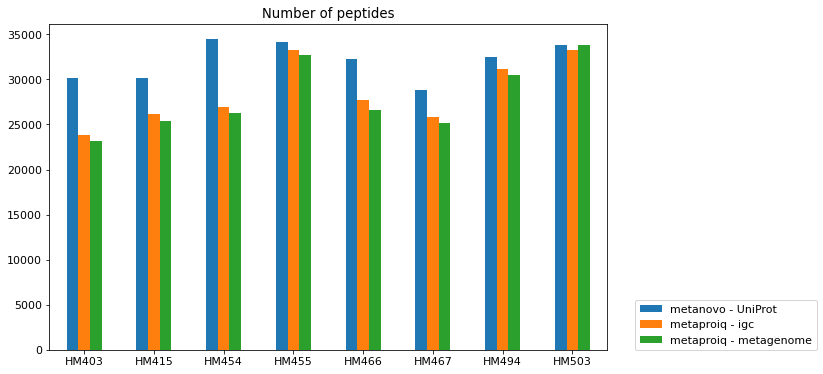

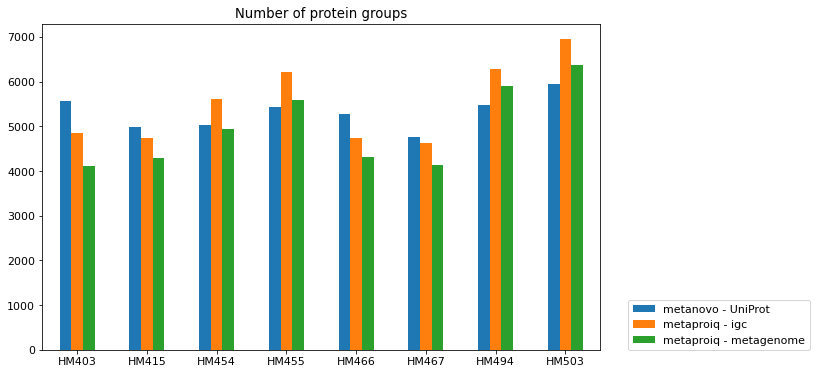

In [112]:
keys = list(results.keys())
plt.clf()
# Peptide counts per sample
count_df = pd.DataFrame()
for name in order:
    target_peptides = results[name]['TargetPeptides']
    for col in target_peptides.columns:
        if col.startswith('Experiment'):
            seqs = set(target_peptides[(target_peptides[col] > 0)]['Sequence'].tolist())
            count_df.loc[col.split()[1], name] = int(len(seqs))
ax1 = count_df.plot(kind='bar', rot=1,figsize=(10,6))
ax1.set_title("Number of peptides")
ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
fig = ax1.get_figure()
fig.savefig('analysis/figures/fig_3a.png', bbox_inches='tight', dpi=600)
plt.xticks(rotation=0)

plt.show()

# Protein counts per sample
prot_count = pd.DataFrame()
for name in order:
    target_proteins = results[name]['TargetProteins']
    for col in target_proteins.columns:
        if col.startswith('MS/MS Count '):
            ids = set(target_proteins[(target_proteins[col] > 0)]['id'].tolist())
            prot_count.loc[col.split()[-1], name] = int(len(ids))
ax2 = prot_count.plot(kind='bar', rot=1,figsize=(10,6))
ax2.set_title("Number of protein groups")
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
fig = ax2.get_figure()
plt.xticks(rotation=0)
plt.show()

### 1.3 PEP Score Boxplots

#### Fgure 3d

metanovo - UniProt exclusive:  14049
metaproiq - igc exclusive:  4873
metaproiq - metagenome exclusive:  6525


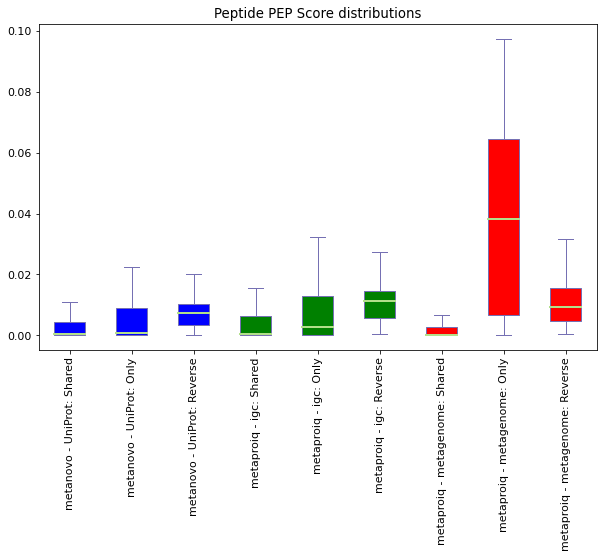

In [113]:
##################
## Peptide Sets ##
##################
all_peps = set()
keys = list(results.keys())
names = []
pep_scores = []
for key in order:
    peps = set(results[key]['TargetPeptides']['Sequence'])
    all_peps.update(peps)
# Get common peptides to all runs
intersect = all_peps.copy()
for key in order:
    peps = set(results[key]['TargetPeptides']['Sequence'])
    intersect = intersect & peps
# Get esclusive peptides for all runs
for key in order:
    peps = results[key]['TargetPeptides']
    rpeps = results[key]['ReversePeptides']
    exclusive = set(peps['Sequence'].tolist()).copy()
    for qkey in keys:
        if not qkey == key:
            qpeps = results[qkey]['TargetPeptides']
            qpeps = set(qpeps['Sequence'].tolist())
            exclusive -= qpeps
    print('{} exclusive: '.format(key), len(exclusive))
    common_pep = peps[peps['Sequence'].isin(intersect)]['PEP'].tolist()
    pep_scores.append(common_pep)
    names.append(key + ': Shared')
    exclusive_pep = peps[peps['Sequence'].isin(exclusive)]['PEP'].tolist()
    pep_scores.append(exclusive_pep)
    names.append(key + ': Only')
    reverse_pep = rpeps['PEP'].tolist()
    pep_scores.append(reverse_pep)
    names.append(key + ': Reverse')


#############
## BOXPLOT ##
#############
colours = ['b','g','r','c','m','y','k']
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(np.array(pep_scores, dtype=object), patch_artist=True, showfliers=False)
## change outline color, fill color and linewidth of the boxes
count = 0
col_ind=0
for box in bp['boxes']:
    count += 1
    # change outline color
    box.set( color='#7570b3', linewidth=1)
    # change fill color
    box.set( facecolor = colours[col_ind] )
    ## change color and linewidth of the whiskers
    if count % 3 == 0:
        col_ind +=1
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=1)
# change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=1)
# change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)
# change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='.', color='#e7298a', alpha=0.5)
# Custom x-axis labels
ax.set_xticklabels(names, rotation=90) 
ax.set_title('Peptide PEP Score distributions')
## Remove top axes and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
fig.savefig('analysis/figures/fig_3d.png', bbox_inches='tight',dpi=600)
plt.show()
fig.clf()

#### S3 Figure - Density plot of peptide PEP scores by group

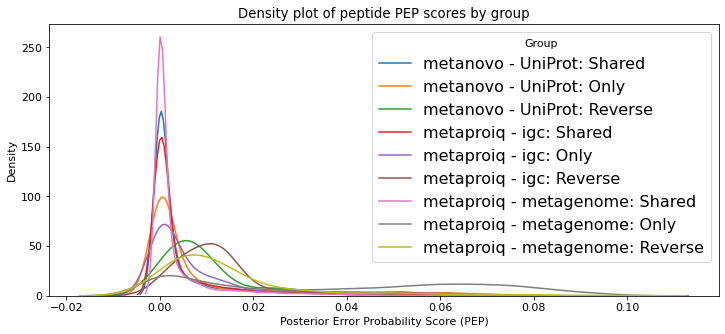

In [114]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

fig = plt.figure(figsize=(12, 5))

for name in names:
    _ = pd.DataFrame( { name : pep_scores[names.index(name)] } )
    # Draw the density plot
    sns.kdeplot(pep_scores[names.index(name)], label=name)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Group')
plt.title('Density plot of peptide PEP scores by group')
plt.xlabel('Posterior Error Probability Score (PEP)')
plt.ylabel('Density')

fig.savefig('analysis/supplementary/S3_figure.png', bbox_inches='tight',dpi=600)
plt.show()

#### S4 Table - Peptide PEP Scores comparison

In [115]:
pep_df = pd.DataFrame()
for val in range(len(names)):
    pep_df.loc[names[val], 'Count'] = len(pep_scores[val])
    pep_df.loc[names[val], 'PEP Score - median'] = np.median(pep_scores[val])
    pep_df.loc[names[val], 'PEP Score - std. dev.'] = np.std(pep_scores[val])

pep_df.to_csv('analysis/supplementary/S4_table.csv')
pep_df

,Count,PEP Score - median,PEP Score - std. dev.
metanovo - UniProt: Shared,48705.0,0.000260,0.012193
metanovo - UniProt: Only,14049.0,0.000799,0.017173
metanovo - UniProt: Reverse,185.0,0.007231,0.013012
metaproiq - igc: Shared,48705.0,0.000373,0.013737
metaproiq - igc: Only,4873.0,0.002632,0.016785
metaproiq - igc: Reverse,223.0,0.011263,0.011878
metaproiq - metagenome: Shared,48705.0,0.000126,0.008828
metaproiq - metagenome: Only,6525.0,0.038306,0.030075
metaproiq - metagenome: Reverse,206.0,0.009337,0.016834


### 1.4 PEP Score Kruskal-Wallis

In [116]:
post_hoc = metanovo_functions.list_kw_dunn(names, pep_scores, "PEP", "Workflow", outfolder)
post_hoc

KruskalResult(statistic=10883.939894469078, pvalue=0.0)


,metanovo - UniProt: Shared,metanovo - UniProt: Only,metanovo - UniProt: Reverse,metaproiq - igc: Shared,metaproiq - igc: Only,metaproiq - igc: Reverse,metaproiq - metagenome: Shared,metaproiq - metagenome: Only,metaproiq - metagenome: Reverse
metanovo - UniProt: Shared,1.000000e+00,3.734901e-87,1.729789e-39,3.773263e-32,4.537713e-216,1.541020e-60,7.627574e-72,0.000000e+00,1.569875e-53
metanovo - UniProt: Only,3.734901e-87,1.000000e+00,6.330437e-26,1.158218e-32,3.620188e-64,1.281311e-41,2.606551e-222,0.000000e+00,1.481513e-36
metanovo - UniProt: Reverse,1.729789e-39,6.330437e-26,1.000000e+00,7.918533e-34,3.192363e-11,2.014311e-01,5.813792e-49,3.362623e-02,3.147086e-01
metaproiq - igc: Shared,3.773263e-32,1.158218e-32,7.918533e-34,1.000000e+00,9.163935e-153,9.235974e-53,1.125309e-194,0.000000e+00,1.536492e-46
metaproiq - igc: Only,4.537713e-216,3.620188e-64,3.192363e-11,9.163935e-153,1.000000e+00,3.148180e-20,0.000000e+00,4.475586e-267,1.827976e-17
metaproiq - igc: Reverse,1.541020e-60,1.281311e-41,2.014311e-01,9.235974e-53,3.148180e-20,1.000000e+00,2.271949e-73,6.870360e-01,7.870152e-01
metaproiq - metagenome: Shared,7.627574e-72,2.606551e-222,5.813792e-49,1.125309e-194,0.000000e+00,2.271949e-73,1.000000e+00,0.000000e+00,3.725671e-65
metaproiq - metagenome: Only,0.000000e+00,0.000000e+00,3.362623e-02,0.000000e+00,4.475586e-267,6.870360e-01,0.000000e+00,1.000000e+00,4.598942e-01
metaproiq - metagenome: Reverse,1.569875e-53,1.481513e-36,3.147086e-01,1.536492e-46,1.827976e-17,7.870152e-01,3.725671e-65,4.598942e-01,1.000000e+00


### 1.5 Venn Diagrams

#### Figure 3b

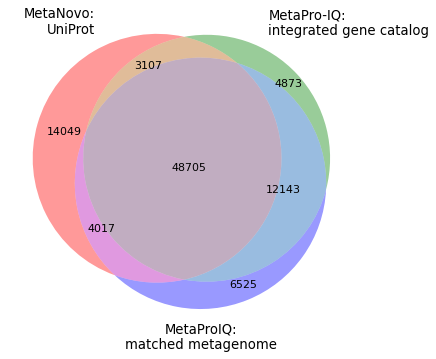

In [117]:
set1 = set(results['metanovo - UniProt']['TargetPeptides']['Sequence'])
set2 = set(results['metaproiq - igc']['TargetPeptides']['Sequence'])
set3 = set(results['metaproiq - metagenome']['TargetPeptides']['Sequence'])
fig = plt.figure(figsize=(10,6))
venn3([set1, set2, set3], ('MetaNovo:\nUniProt', 'MetaPro-IQ:\nintegrated gene catalog', 'MetaProIQ:\nmatched metagenome'))
fig.savefig('analysis/figures/fig_3b.png', bbox_inches='tight',dpi=600)
plt.show()

In [118]:
mg = set(results['metaproiq - metagenome']['TargetPeptides']['Sequence']) - set(results['metaproiq - igc']['TargetPeptides']['Sequence'])
print(len(mg))
mn = set(results['metanovo - UniProt']['TargetPeptides']['Sequence']) & mg
print(len(mn))

10542
4017


### 1.6 UniPept v2.0.0

In [119]:
print('All peptides found: ', len(all_peps))
w=open( outfolder + '/combined_mpi_peptide_set.txt','w')
w.write('\n'.join(all_peps))
w.close()
cmd = 'cat analysis/mli/combined_mpi_peptide_set.txt | prot2pept | peptfilter | sort -u | unipept pept2lca -e -a > analysis/mli/combined_mpi_pept2lca.csv || rm analysis/mli/combined_mpi_pept2lca.csv'
# run this in terminal
print('Please run this command in terminal in the root directory of the repo: \n' + cmd)
# Please use the file provided in Supplemental Data to use the ouput of UniPept at the time of writing


All peptides found:  93419
Please run this command in terminal in the root directory of the repo: 
cat analysis/mli/combined_mpi_peptide_set.txt | prot2pept | peptfilter | sort -u | unipept pept2lca -e -a > analysis/mli/combined_mpi_pept2lca.csv || rm analysis/mli/combined_mpi_pept2lca.csv


In [120]:
taxa = pd.read_csv('analysis/mli/combined_mpi_pept2lca.csv', low_memory=False)
template = pd.DataFrame(pd.Series(list(all_peps)))
template.rename(columns={0:'peptide'}, inplace=True)
smapping = pd.merge(template, taxa, how='inner')

#### S5-6

<Figure size 432x288 with 0 Axes>

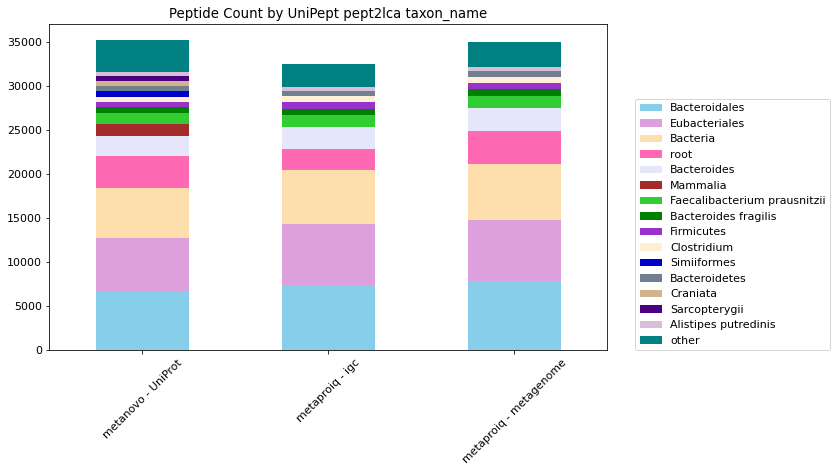

Empty DataFrame
Columns: [metanovo - UniProt, metaproiq - igc, metaproiq - metagenome]
Index: []
               metanovo - UniProt  metaproiq - igc  metaproiq - metagenome
taxon_name                                                                
Mammalia                     1406                0                       0
Simiiformes                   673                0                       0
Craniata                      563                0                       0
Sarcopterygii                 540                0                       0
Homo sapiens                  392                0                       0
Metazoa                       391                0                       0
Eukaryota                     292                0                       0
Homininae                     272                0                       0
Total                        4529                0                       0
                              metanovo - UniProt  metaproiq - igc  \
taxon_nam

In [98]:
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'taxon_name', smapping, order, 0.5, level='peptide', fname='analysis/figures/fig_3c.png')
met_only_taxa = count_df[count_df['metaproiq - igc'] == 0].copy()
met_skipped_taxa = count_df[count_df['metanovo - UniProt'] == 0].copy()
print(met_skipped_taxa)

met_only_taxa.loc['Total'] = met_only_taxa.sum()
met_only_taxa.to_csv('analysis/supplementary/S5_table.csv')
print(met_only_taxa)

count_df.loc['Total'] = count_df.sum()
count_df.to_csv('analysis/supplementary/S6_table.csv')
print(count_df)

<Figure size 432x288 with 0 Axes>

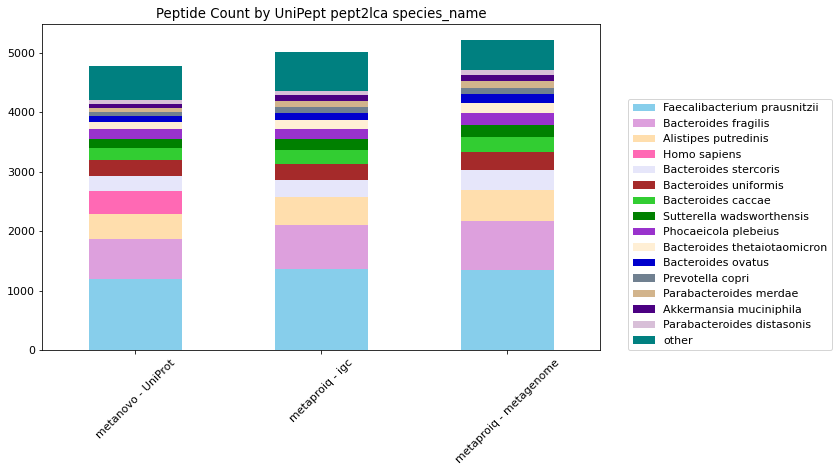

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
species_name,,,
Faecalibacterium prausnitzii,1202,1374,1354
Bacteroides fragilis,672,732,814
Alistipes putredinis,418,476,529
Homo sapiens,392,0,0
Bacteroides stercoris,245,274,326
Bacteroides uniformis,267,283,310
Bacteroides caccae,200,220,250
Sutterella wadsworthensis,159,196,207
Phocaeicola plebeius,159,161,197


In [99]:
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'species_name', smapping, order, 0.5, level='peptide')
count_df

<Figure size 432x288 with 0 Axes>

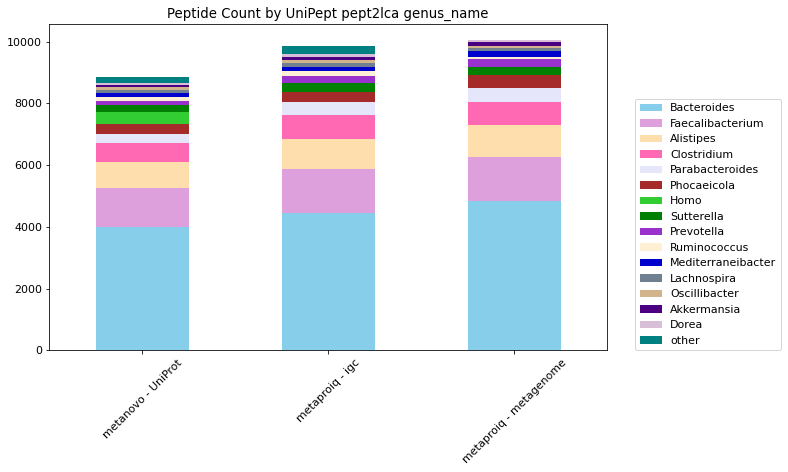

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
genus_name,,,
Bacteroides,3987,4436,4829
Faecalibacterium,1254,1439,1422
Alistipes,863,979,1060
Clostridium,597,763,737
Parabacteroides,310,435,441
Phocaeicola,331,323,417
Homo,392,0,0
Sutterella,207,271,277
Prevotella,126,222,237


In [100]:
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'genus_name', smapping, order, 0.5, level='peptide')
count_df

<Figure size 432x288 with 0 Axes>

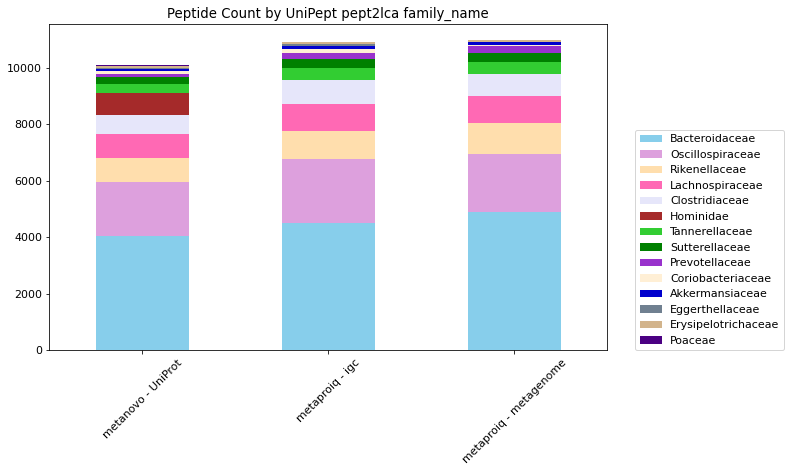

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
family_name,,,
Bacteroidaceae,4058,4514,4908
Oscillospiraceae,1892,2248,2061
Rikenellaceae,871,987,1069
Lachnospiraceae,854,975,953
Clostridiaceae,654,848,779
Hominidae,793,0,0
Tannerellaceae,313,441,447
Sutterellaceae,227,297,300
Prevotellaceae,134,235,247


In [101]:
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'family_name', smapping, order, 0.5, level='peptide')
count_df

<Figure size 432x288 with 0 Axes>

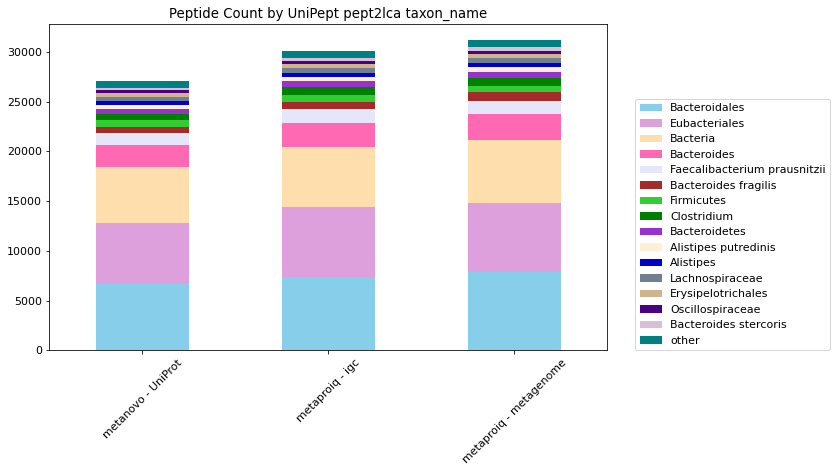

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
taxon_name,,,
Bacteroidales,6687,7369,7875
Eubacteriales,6074,7005,6931
Bacteria,5675,6039,6358
Bacteroides,2192,2425,2595
Faecalibacterium prausnitzii,1200,1372,1351
Bacteroides fragilis,669,732,812
Firmicutes,660,758,689
Clostridium,585,742,721
Bacteroidetes,560,585,632


In [102]:
taxon_filter = {"superkingdom_name":"Bacteria"}

order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']

count_df = metanovo_functions.plot_taxa(results, 'taxon_name', smapping, order, filt=0.5, level='peptide', taxon_filter=taxon_filter, filter_method='include',fname='analysis/supplementary/S7_figure.png')
count_df = count_df.astype('int')
count_df.loc['Total'] = count_df.sum()

count_df

### S8 Table

<Figure size 432x288 with 0 Axes>

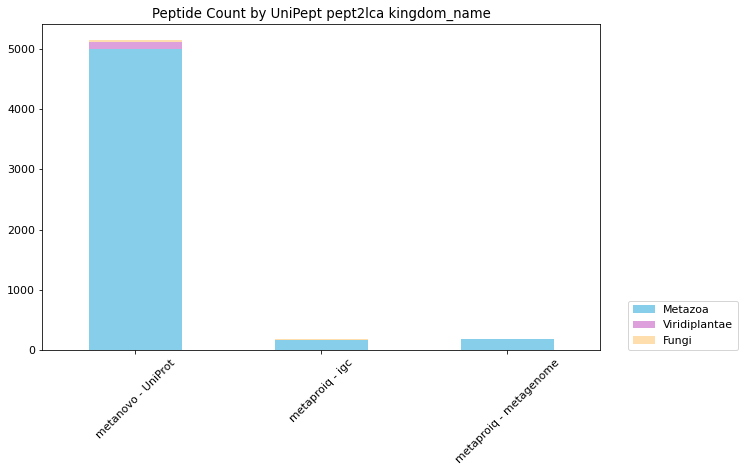

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
kingdom_name,,,
Metazoa,4994,176,185
Viridiplantae,119,2,1
Fungi,34,4,3
Total,5147,182,189


In [78]:
taxon_filter = {}
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'kingdom_name', smapping, order, filt=0.5, level='peptide')
count_df = count_df.astype('int')
count_df.loc['Total'] = count_df.sum()
count_df.to_csv('analysis/supplementary/S8_table.csv')
count_df

### S9 Table

<Figure size 432x288 with 0 Axes>

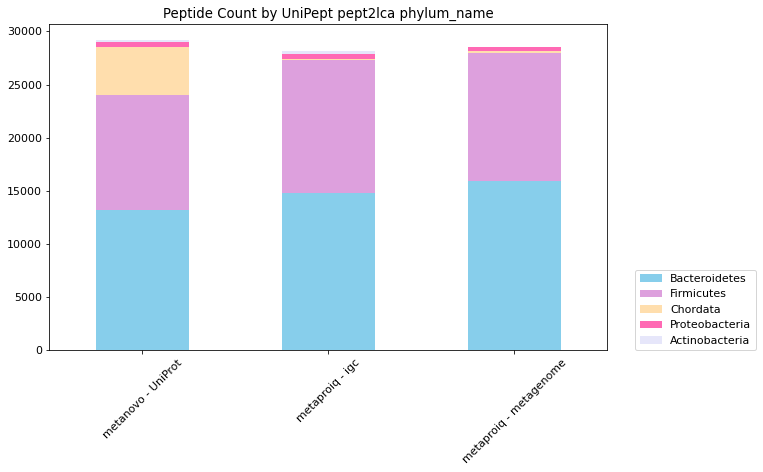

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
phylum_name,,,
Bacteroidetes,13243,14750,15887
Firmicutes,10763,12518,12040
Chordata,4566,168,178
Proteobacteria,403,409,399
Actinobacteria,240,296,0
Total,29215,28141,28504


In [79]:
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'phylum_name', smapping, order, 0.5, level='peptide')
count_df.loc['Total'] = count_df.sum()
count_df.to_csv('analysis/supplementary/S9_table.csv')
count_df

<Figure size 432x288 with 0 Axes>

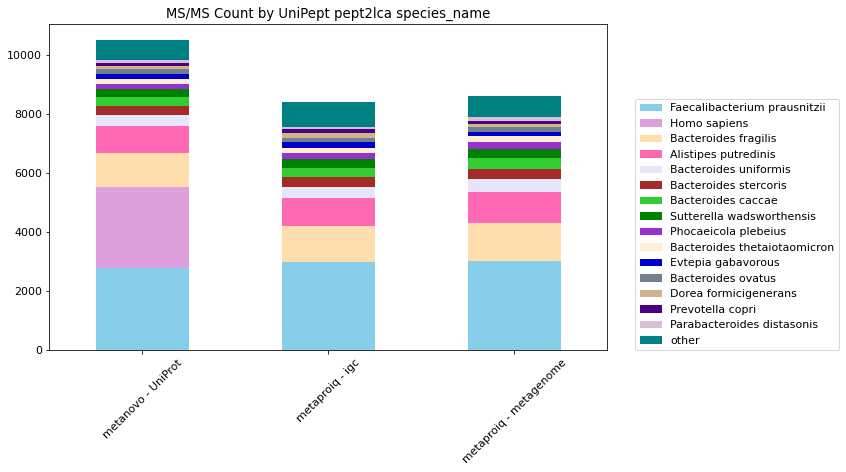

,metanovo - UniProt,metaproiq - igc,metaproiq - metagenome
species_name,,,
Faecalibacterium prausnitzii,2776,3006,3031
Homo sapiens,2765,0,0
Bacteroides fragilis,1136,1194,1293
Alistipes putredinis,931,970,1048
Bacteroides uniformis,376,382,424
Bacteroides stercoris,287,311,363
Bacteroides caccae,301,324,353
Sutterella wadsworthensis,281,303,325
Phocaeicola plebeius,186,185,225


In [80]:
order = ['metanovo - UniProt', 'metaproiq - igc' , 'metaproiq - metagenome']
count_df = metanovo_functions.plot_taxa(results, 'species_name', smapping, order, level='msms', filt=0.5)
count_df

# Figure 3

In [64]:
metanovo_functions.concat_4way_image('analysis/figures/fig_3a.png',
                                     'analysis/figures/fig_3b.png',
                                     'analysis/figures/fig_3c.png',
                                     'analysis/figures/fig_3d.png',
                                     'analysis/figures/fig_3_combined.png' )